In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

In [3]:
def mcz(circuit, control_qubits, target_qubit):
    circuit.h(target_qubit)
    circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli
    circuit.h(target_qubit)

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli
/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


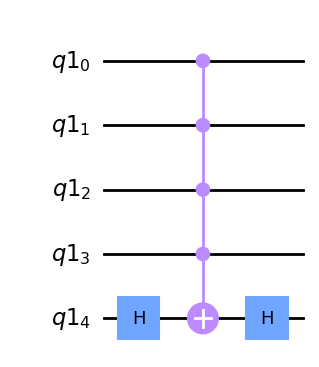

In [4]:
quamtum_reg_5 = QuantumRegister(5)
circuit_mcz = QuantumCircuit(quamtum_reg_5)
mcz(circuit_mcz, quamtum_reg_5[:4], quamtum_reg_5[4])
circuit_mcz.draw('mpl')

In [5]:
def Grover_Diffuser(circuit, target_reg):
    
    n = target_reg.size

    # Apply transformation |s> -> |00..0> (H-gates)
    for i in range(n):
        circuit.h(target_reg[i])

    # Apply transformation |00..0> -> |11..1> (X-gates)
    for i in range(n):
        circuit.x(target_reg[i])

    # Do multi-controlled-Z gate
    mcz(circuit, target_reg[list(range(n-1))], target_reg[n-1])

    # Apply transformation |11..1> -> |00..0>
    for i in range(n):
        circuit.x(target_reg[i])

    # Apply transformation |00..0> -> |s>
    for i in range(n):
        circuit.h(target_reg[i])

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


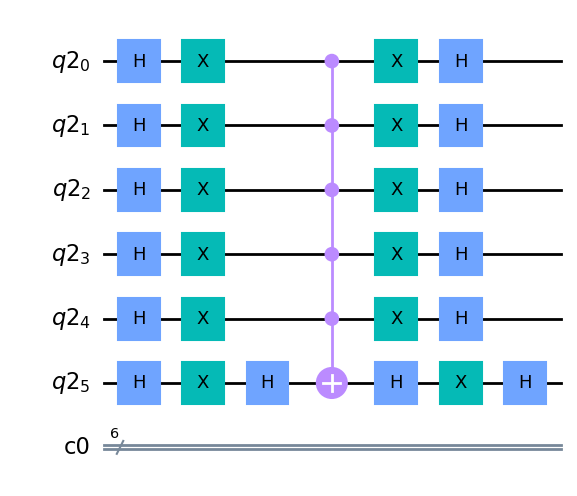

In [6]:
n = 6

quantum_reg = QuantumRegister(n)
classic_reg = ClassicalRegister(n)

circuit_difuser = QuantumCircuit(quantum_reg, classic_reg)

Grover_Diffuser(circuit_difuser, quantum_reg)

circuit_difuser.draw(output='mpl')

In [7]:
def Grover_Oracle_trivial(circuit, target_reg, M_list_bin_qiskit): # n, M_list_bin):
	'''
	This function implements a Grover oracle. We call it "trivial" because this
	oracle change the sign of some given states. That is, we know the solution 
	in advance. (For example, we want to find the states |101> and |110> among 
	the 8 possible ones. We know from the begining the states we want to find.)

	We can use the multicontrolled Z gate (mcz) we defined earlier to change the
	sign of any M_list_bin[i] state. Simply apply X gates before and after the 
	mcz on the qubits that are worth zero in M_list_bin[i].

	IMPORTANT !!!: Remember that if we deal with qiskit, the binary strings have
	to 	come upside	down (with the LEASTE SIGNIFICANT BIT AT THE BEGINNING !!!).

	Inputs:
		- circuit: Quantum Circuit

		- target_reg: Quantum Register (with n qubits) in which we are going to 
			search and change the sign of some given states. It must be one 
			Quantum Register of the previus circuit.
		
		- M_list_bin: Python List with the states that we want to find. The 
			states must be in binary and must have length n.

	'''
	n = target_reg.size

	for m in M_list_bin_qiskit:
		for i in range(len(m)):
			if m[i] == '0':
				circuit.x(target_reg[i])

		mcz(circuit, target_reg[list(range(n-1))], target_reg[n-1])
	    
		for i in range(len(m)):
			if m[i] == '0':
				circuit.x(target_reg[i])

In [8]:
def Iterations_T(N, M):
    
    return int(np.pi/4 * np.sqrt(N/M))

In [9]:
n = 4
N = 2**n # Total number of states
M_list_bin_qiskit = [ '0101', '1100']
M = len(M_list_bin_qiskit)

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


The circuit has been built (4 qubits)

Number of Grover iteration: 2


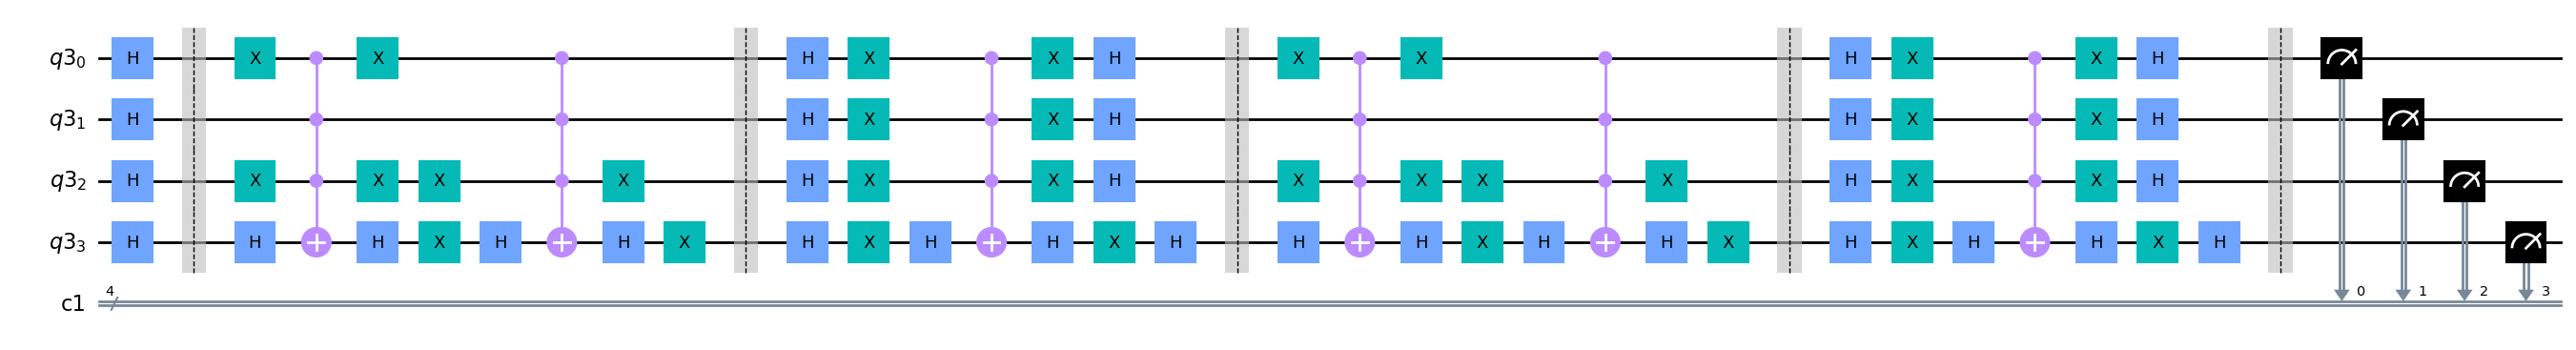

In [10]:
# We build the citcuit with the quantum registers
quantum_reg = QuantumRegister(n)
classic_reg = ClassicalRegister(n)
circuit_t = QuantumCircuit(quantum_reg, classic_reg)
    
# ======================================================
# We apply the initialization function. This time we use H^n
for qubit in quantum_reg:
    circuit_t.h(qubit)

circuit_t.barrier()
  
# ======================================================
# Number of iterations
T = Iterations_T(N, M)
       
# ======================================================
# We add the grover oracle and diffuser T times

for _ in range(T):
    Grover_Oracle_trivial(circuit_t, quantum_reg, M_list_bin_qiskit)
    circuit_t.barrier()
    Grover_Diffuser(circuit_t, quantum_reg)
    circuit_t.barrier()

# ======================================================
# Measure all qubits on the quantum_reg into the classic_reg

circuit_t.measure(quantum_reg, classic_reg)

# ======================================================
print(f'The circuit has been built ({n} qubits)')
print(f'\nNumber of Grover iteration: {T}')
print('====================================================')
circuit_t.draw('mpl', fold = -1)

In [11]:
sim = AerSimulator(method = 'statevector') 

t_circuit_t = transpile(circuit_t, backend = sim) #, optimization_level = 3)
result = sim.run(t_circuit_t, shots = 10000).result()

counts = result.get_counts()

# ======================================================
# We order the states from most counts to least

# keys = list(counts.keys())

keys_bin = list(counts.keys())
keys = keys_bin
#keys = [int(keys_bin[i],2) for i in range(len(keys_bin))] 

values = list(counts.values())
zip_list = zip(keys,values)
zip_sorted = list(sorted(zip_list, key = lambda x: -x[1]))
keys, values = zip(*list(zip_sorted))
        
num_sols = len(list(zip_sorted))
        
print_range = M + 2 
if num_sols < print_range:
    print_range = num_sols

print(f'\nThe algorithm found {num_sols} results.')
print(f'The {print_range} results with more counts are:')
print('\n   Result | Counts')
for i in range(print_range):
    print('   ',list(zip_sorted)[i])



The algorithm found 16 results.
The 4 results with more counts are:

   Result | Counts
    ('1010', 4802)
    ('0011', 4671)
    ('0100', 47)
    ('1011', 46)


In [12]:
conditions_list = [ [0,1],  [0,2],  [1,3],  [2,3] ]

In [13]:
def XOR_2qubits(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


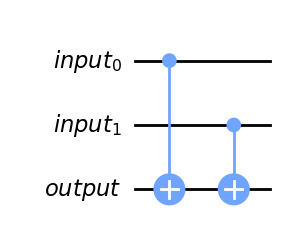

In [14]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR_2qubits(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output = 'mpl')

In [15]:
def Grover_Oracle_Sudoku_2x2(circuit, conditions_list, ancilla_reg, 
			                 output_qubit, print_oracle = 1):
	'''
	This oracle solves the problem of a Sudoku 2x2. 
	'''
	# Compute clauses
	i = 0
	for clause in conditions_list:
		XOR_2qubits(circuit, clause[0], clause[1], ancilla_reg[i])
		i += 1

	# Flip 'output' bit if all clauses are satisfied
	circuit.mct(ancilla_reg, output_qubit)

	# Uncompute clauses to reset clause-checking bits to 0
	i = 0
	for clause in conditions_list:
		XOR_2qubits(circuit, clause[0], clause[1], ancilla_reg[i])
		i += 1

	if print_oracle == 0:
		circuit.draw(output='mpl', fold = -1, filename = '3-Fig_Oracle_Sudoku_2x2')

In [16]:
def Iterations_T(N, M):
    
    return int(np.pi/4 * np.sqrt(N/M))

/tmp/ipykernel_104226/4069349661.py:13: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(ancilla_reg, output_qubit)
/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


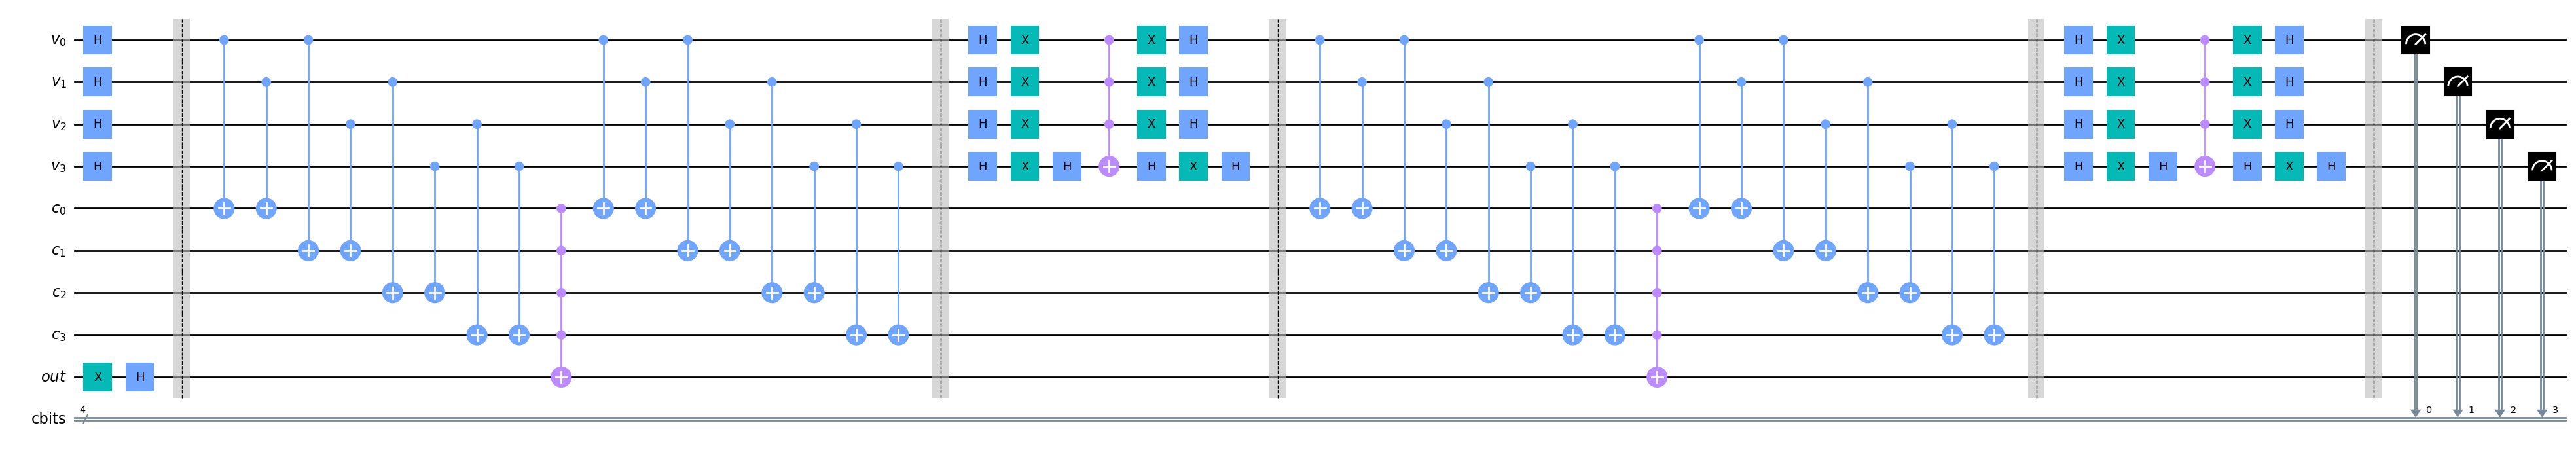

In [17]:
conditions_list = [ [0,1],  [0,2],  [1,3],  [2,3] ]

n = 4
N = 2**n # Total number of states
M = 2    # Number of solutions

# Registers
var_reg = QuantumRegister(n, name='v')
ancilla_reg = QuantumRegister(len(conditions_list), name='c')
output_qubit = QuantumRegister(1, name='out')
classic_reg = ClassicalRegister(n, name='cbits')

# Circuit
circuit_sudo = QuantumCircuit(var_reg, ancilla_reg, output_qubit, classic_reg)

# Initialize 'out0' in state |->
circuit_sudo.x(output_qubit)
circuit_sudo.h(output_qubit)

# Initialize qubits in state |s>
circuit_sudo.h(var_reg)
circuit_sudo.barrier()  # for visual separation

T = Iterations_T(N,M)

for i in range(T):
    Grover_Oracle_Sudoku_2x2(circuit_sudo, conditions_list, ancilla_reg, 
                  output_qubit, print_oracle = 1)
    circuit_sudo.barrier()  # for visual separation
    Grover_Diffuser(circuit_sudo, var_reg)
    circuit_sudo.barrier()  # for visual separation



# Measure the variable qubits
circuit_sudo.measure(var_reg, classic_reg)


circuit_sudo.draw(output='mpl', fold = -1)



In [18]:
sim = AerSimulator(method = 'statevector')
t_circuit_sudo = transpile(circuit_sudo, sim)
result = sim.run(t_circuit_sudo).result()

counts = result.get_counts()

keys_bin = list(counts.keys())


values = list(counts.values())
zip_list = zip(keys_bin,values)
zip_sorted = list(sorted(zip_list, key = lambda x: -x[1]))
keys_bin, values = zip(*list(zip_sorted))

num_sols = len(list(zip_sorted))

print_range = 2 + 2 
if num_sols < print_range:
    print_range = num_sols

print('Solving the sudoku 2x2:')
print('    v0  v1')
print('    v2  v3')
print('The results takes the form: v0v1v2v3')
print(f'\nThe algorithm found {num_sols} results.')
print(f'The {print_range} results with more counts are:')
print('\n   Result | Counts')
for i in range(print_range):
    print('  ',list(zip_sorted)[i])

fig = plot_histogram(result.get_counts())

fig.tight_layout()

fig

Solving the sudoku 2x2:
    v0  v1
    v2  v3
The results takes the form: v0v1v2v3

The algorithm found 16 results.
The 4 results with more counts are:

   Result | Counts
   ('1001', 500)
   ('0110', 465)
   ('0001', 9)
   ('0101', 9)
